In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import quad
from scipy.special import beta as Beta
import pandas as pd
import seaborn as sns
import itertools
import warnings
import scipy.optimize as optimize
from joblib import Parallel, delayed
from tqdm import trange
from collections import namedtuple


sns.set_style('ticks')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 1.5})
sns.set_palette('bright')


Params = namedtuple('Parameters', ['mu', 'sigma', 'alpha', 'beta', 'p'])
str2float = lambda x: [float(k) for k in x[1:-1].split(',')]

<Figure size 640x480 with 0 Axes>

# Parameter Estimation

## Density Functions in the IBN Model

In [6]:
def f_SC(c: float, mu: float, sigma: float, alpha: float, beta: float, pi: float) -> float:
    """ Density function of standing cycles (SC) in the IBN model. """
    if c < 0:
        return 0
    
    f_C = lambda c: stats.truncnorm.pdf(c, -mu/sigma, np.inf, loc=mu, scale=sigma)

    # BN:
    if not pi:
        return f_C(c)
    
    # IBN:
    xi = lambda x: x**(beta - 3) * (1 - x)**(alpha - 1)

    summand1 = (1 - pi) / (1 + pi) * f_C(c)

    factor2 = 2 * pi / ((1 + pi) * Beta(beta, alpha))

    I = lambda v: quad(xi, v, 1)[0]
    summand2 = factor2 * quad(lambda y: f_C(y) / y**2 * (c* I(c/y) + (y - c) * I(1 - c/y)), c, np.inf)[0]  # Lemma 5.1

    return summand1 + summand2


def f_LF(c: float, alpha: float, beta: float, pi: float) -> float:
    """ Density function of lying fractions (LF) in the IBN model. """
    if c < 0 or c > 1:
        return 0
    
    f_F = lambda x: stats.beta.pdf(x, alpha, beta)

    # BN:
    if not pi:
        return f_F(c)
    
    # IBN:
    z = 1/c - 1
    summand1 = (1 - pi) / (1 + pi) * f_F(c)

    summand2 = pi / (1 + pi)

    factor3 = 2 * pi / ((1 + pi) * c**2)

    I = lambda x: stats.betaprime.pdf(x, beta, alpha) * (1 - z/x) / x

    summand3 = factor3 * quad(I, z, np.inf)[0]

    return summand1 + summand2 + summand3

Method of Moments estimator for Beta distribution:

In [7]:
alpha_mom = lambda l: np.mean(l) * (np.mean(l) * (1 - np.mean(l)) / np.var(l) - 1)
beta_mom = lambda l: (1 - np.mean(l)) * (np.mean(l) * (1 - np.mean(l)) / np.var(l) - 1)

## Fitting function in the (I)BN

BN:

In [ ]:
def _fit_BN(alpha_mom, beta_mom,
			x_scs, y_scs, factor_scs,
			x_lfs, y_lfs, factor_lfs):
	
	eps = np.finfo(np.float32).eps
	
	x = np.array([b for b in x_scs] + [b for b in x_lfs])
	y = np.array([factor_scs*b for b in y_scs]  + [factor_lfs*b for b in y_lfs])

	def compute_SC(x, mu, sigma, a, b, factor_scs):
		return factor_scs * f_SC(x, mu, sigma, a, b, 0)

	def compute_LF(x, a, b, factor_lfs):
		return factor_lfs * f_LF(x, a, b, 0)

	def f(_x, mu, sigma, a, b):
		split_index = len(_x) // 2
		y1 = Parallel(n_jobs=-1)(delayed(compute_SC)(x, mu, sigma, a, b, factor_scs) for x in _x[:split_index])
		y2 = Parallel(n_jobs=-1)(delayed(compute_LF)(x, a, b, factor_lfs) for x in _x[split_index:])
		return np.concatenate((y1, y2))

	with warnings.catch_warnings(record=True) as w:
		warnings.simplefilter("always")
		scs = list(x_scs)
		result = optimize.curve_fit(f, x, y, p0=[np.mean(scs) + 30, np.std(scs), alpha_mom, beta_mom],
									bounds=(eps, (660, 660, 1_000, 1_000)), diff_step=0.01)[0]
		if any(issubclass(w.category, UserWarning) for w in w):
			warning_occured = True
		else:
			warning_occured = False
		optimal_value = np.sum((f(x, *result) - y)**2)

	return *result, optimal_value, float(warning_occured)  # 8 values


def fit_BN(scs, lfs, bins=40):
	alpha_moms = alpha_mom(lfs)
	beta_moms = beta_mom(lfs)

	b_y, b_x = np.histogram(scs, bins=bins, density=True)
	dx = b_x[1] - b_x[0]
	factor_scs = dx
	x_scs = b_x[:-1] + dx/2
	y_scs = b_y.copy()


	b_y, b_x = np.histogram(lfs, bins=bins, density=True)
	dx = b_x[1] - b_x[0]
	factor_lfs = dx
	x_lfs = b_x[:-1] + dx/2
	y_lfs = b_y.copy()

	return _fit_BN(alpha_moms, beta_moms, x_scs, y_scs, factor_scs, x_lfs, y_lfs, factor_lfs) 

IBN:

In [9]:
def fit_IBN(scs, lfs, bins=40):
	eps = np.finfo(np.float32).eps

	alpha_moms = alpha_mom(lfs)
	beta_moms = beta_mom(lfs)

	b_y, b_x = np.histogram(scs, bins=bins, density=True)
	dx = b_x[1] - b_x[0]
	factor_scs = dx
	x_scs = b_x[:-1] + dx/2
	y_scs = b_y.copy()

	b_y, b_x = np.histogram(lfs, bins=bins, density=True)
	dx = b_x[1] - b_x[0]
	factor_lfs = dx
	x_lfs = b_x[:-1] + dx/2
	y_lfs = b_y.copy()

	
	x = np.array([b for b in x_scs] + [b for b in x_lfs])
	y = np.array([factor_scs*b for b in y_scs]  + [factor_lfs*b for b in y_lfs])

	def compute_SC(x, mu, sigma, a, b, p, factor_scs):
		return factor_scs * f_SC(x, mu, sigma, a, b, p/100)

	def compute_LF(x, a, b, p, factor_lfs):
		return factor_lfs * f_LF(x, a, b, p/100)

	def f(_x, mu, sigma, a, b, p):
		split_index = len(_x) // 2
		y1 = Parallel(n_jobs=-1)(delayed(compute_SC)(x, mu, sigma, a, b, p, factor_scs) for x in _x[:split_index])
		y2 = Parallel(n_jobs=-1)(delayed(compute_LF)(x, a, b, p, factor_lfs) for x in _x[split_index:])
		return np.concatenate((y1, y2))

	results = {}
	for p0 in [0.25, 0.75]:
		with warnings.catch_warnings(record=True) as w:
			warnings.simplefilter("always")
			scs = list(x_scs)
			result = optimize.curve_fit(f, x, y, p0=[np.mean(scs) + 30, np.std(scs), alpha_moms, beta_moms, p0*100],
										bounds=(eps, (660, 660, 1_000, 1_000, 100)), diff_step=0.01)[0]
			if any(issubclass(w.category, UserWarning) for w in w):
				warning_occured = True
			else:
				warning_occured = False
			optimal_value = np.sum((f(x, *result) - y)**2)
			results[p0] = (*result[:4], result[4]/100, optimal_value, float(warning_occured))

	optimal_values = {key: results[key][-2] for key in results}
	best_fit = min(optimal_values, key=optimal_values.get)
	return *results[best_fit], best_fit  # 8 values

## Fitting function in the S-IBN

In [ ]:
def fit_SIBN(scs1, lfs1, scs2, lfs2, bins=20):
	""" Fit the SIBN model to the data (SCs and LFs of both animals). """
	eps = np.finfo(np.float32).eps

	alpha_moms1 = alpha_mom(lfs1)
	beta_moms1 = beta_mom(lfs1)
	alpha_moms2 = alpha_mom(lfs2)
	beta_moms2 = beta_mom(lfs2)

	b_y, b_x = np.histogram(scs1, bins=bins, density=True)
	dx = b_x[1] - b_x[0]
	factor_scs1 = dx
	x_scs1 = b_x[:-1] + dx/2
	y_scs1 = b_y.copy()

	b_y, b_x = np.histogram(lfs1, bins=bins, density=True)
	dx = b_x[1] - b_x[0]
	factor_lfs1 = dx
	x_lfs1 = b_x[:-1] + dx/2
	y_lfs1 = b_y.copy()

	b_y, b_x = np.histogram(scs2, bins=bins, density=True)
	dx = b_x[1] - b_x[0]
	factor_scs2 = dx
	x_scs2 = b_x[:-1] + dx/2
	y_scs2 = b_y.copy()

	b_y, b_x = np.histogram(lfs2, bins=bins, density=True)
	dx = b_x[1] - b_x[0]
	factor_lfs2 = dx
	x_lfs2 = b_x[:-1] + dx/2
	y_lfs2 = b_y.copy()
	
	x = np.array([b for b in x_scs1] + [b for b in x_scs2] + [b for b in x_lfs1] + [b for b in x_lfs2])
	y = np.array([factor_scs1*b for b in y_scs1] + [factor_scs2*b for b in y_scs2] + [factor_lfs1*b for b in y_lfs1] + [factor_lfs2*b for b in y_lfs2])

	def compute_SC(x, mu, sigma, a, b, p, factor_scs):
		return factor_scs * f_SC(x, mu, sigma, a, b, p/100)

	def compute_LF(x, a, b, p, factor_lfs):
		return factor_lfs * f_LF(x, a, b, p/100)

	def f(_x, mu, sigma, a1, b1, p1, a2, b2, p2):
		split_index = len(_x) // 4
		y1 = Parallel(n_jobs=-1)(delayed(compute_SC)(x, mu, sigma, a1, b1, p1, factor_scs1) for x in _x[:split_index])
		y2 = Parallel(n_jobs=-1)(delayed(compute_SC)(x, mu, sigma, a2, b2, p2, factor_scs2) for x in _x[split_index:2*split_index])
		y3 = Parallel(n_jobs=-1)(delayed(compute_LF)(x, a1, b1, p1, factor_lfs1) for x in _x[2*split_index:3*split_index])
		y4 = Parallel(n_jobs=-1)(delayed(compute_LF)(x, a2, b2, p2, factor_lfs2) for x in _x[3*split_index:])
		return np.concatenate((y1, y2, y3, y4))

	results = {}
	for p0_0, p1_0 in itertools.product([0.25, 0.75], repeat=2):
		with warnings.catch_warnings(record=True) as w:
			warnings.simplefilter("always")
			scs = list(x_scs1) + list(x_scs2)
			result = optimize.curve_fit(f, x, y, p0=[np.mean(scs) + 30, np.std(scs), alpha_moms1, beta_moms1, p0_0*100, alpha_moms2, beta_moms2, p1_0*100],
										bounds=(eps, (660, 660, 1_000, 1_000, 100, 1_000, 1_000, 100)), diff_step=0.01, xtol=1e-1, ftol=1e-1)[0]
			if any(issubclass(w.category, UserWarning) for w in w):
				warning_occured = True
			else:
				warning_occured = False
			optimal_value = np.sum((f(x, *result) - y)**2)
			results[(p0_0, p1_0)] = (*result[:4], result[4]/100, *result[5:7], result[7]/100, optimal_value, float(warning_occured))

	optimal_values = {key: results[key][-2] for key in results}
	best_fit = min(optimal_values, key=optimal_values.get)
	return *results[best_fit], *best_fit  # 11 values

# Simulation of Parameter Estimation

## Simulation of Parameter Estimation in the IBN

Funnctions to simulate nights and imitate pre-processing:

In [ ]:

def remove_small_cycles(binary_list, length=300):
	if not isinstance(binary_list, np.ndarray):
		binary_list = np.array(binary_list)
	nr_removed_phases = 0
	while True:
		indices = np.concatenate(([0], np.where(np.diff(binary_list) != 0)[0] + 1))
		lengths = np.diff(np.concatenate(([0], indices, [len(binary_list)])))[1:]
		if lengths.min() >= length:
			break
		index = np.where(lengths < length)[0][0]
		binary_list[indices[index]:indices[index]+lengths[index]+1] = 1 - binary_list[indices[index]]
		nr_removed_phases += 1
	return binary_list, nr_removed_phases


def generate_night(p1, k=100, max_length=11*60*60, remove_length=300) -> tuple[list[int]]:
	night = []
	while len(night) <= (max_length + 10*p1.mu):
		C = stats.truncnorm.rvs(-p1.mu/p1.sigma, np.inf, loc=p1.mu, scale=p1.sigma, size=k)
		F1 = iter(stats.beta.rvs(p1.alpha, p1.beta, size=k))
		U1 = stats.uniform.rvs(size=(k, 2))
		U_mins1 = iter(np.min(U1, axis=1))
		U_maxs1 = iter(np.max(U1, axis=1))
		P1 = stats.bernoulli.rvs(p1.p, size=k)

		t0 = round(stats.uniform.rvs(0, C[0], size=1)[0])
		C = iter(C)

		for interruption1 in P1:
			c, f1 = round(next(C)), next(F1)
			s1 = round(c * (1 - f1))
			l1 = c - s1

			if not interruption1:
				night += [1] * s1 + [0] * l1
			else:
				u_min, u_max = next(U_mins1), next(U_maxs1)
				s11 = round(s1 * u_min)
				l11 = round(s1 * (u_max - u_min))
				s12 = s1 - s11 - l11
				assert s12 >= 0

				night += [1] * s11 + [0] * l11 + [1] * s12 + [0] * l1
			
	night = night[t0:]
	night = night[:max_length]

	night_trimmed, num_removed_phases = remove_small_cycles(night, remove_length)
	return night, night_trimmed, num_removed_phases


def trim_partial_cycles(n):
	if n[0]:
		n = 1 - np.trim_zeros(1-n, 'f')
	n = np.trim_zeros(n, 'fb')
	n = 1 - np.trim_zeros(1-n, 'b')
	return n


def get_scs_lfs(n):
	n = trim_partial_cycles(n)
	if n.size == 0:
		return [], []
	one_seq = np.split(n, np.where(np.diff(n) != 0)[0] + 1)
	if len(one_seq) == 0:
		return [], []
	one_seq = np.array([len(seq) for seq in one_seq if seq[0] == 1])
	zero_seq = np.split(n, np.where(np.diff(n) != 0)[0] + 1)
	if len(zero_seq) == 0:
		return [], []
	zero_seq = np.array([len(seq) for seq in zero_seq if seq[0] == 0])

	scs = one_seq + zero_seq
	lfs = zero_seq / scs

	return scs, lfs

Function to run Simulations:

In [10]:
def run_simulation_IBN(BINS, RUNS, NIGHTS, P):	
	p = Params(144*60, 40*60, 5.25, 2.52, P)

	nights = np.zeros((RUNS, NIGHTS, 11*60*60), dtype=np.uint8)
	nights_trimmed = np.zeros((RUNS, NIGHTS, 11*60*60), dtype=np.uint8)
	num_removed_phases = np.zeros((RUNS, NIGHTS), dtype=np.uint16)

	for i in trange(RUNS):
		for j in range(NIGHTS):
			nights[i][j], nights_trimmed[i][j], num_removed_phases[i][j] = generate_night(p)

	scs, lfs = [], []
	scs_trimmed, lfs_trimmed = [], []
	for i in trange(RUNS):
		scs_, lfs_, = [], []
		scs_trimmed_, lfs_trimmed_ = [], []

		for j in range(NIGHTS):
			scs__, lfs__ = get_scs_lfs(nights[i][j])
			scs_.extend([s/60 for s in scs__])
			lfs_.extend(lfs__)
		scs.append(scs_)
		lfs.append(lfs_)

		for j in range(NIGHTS):
			scs__, lfs__ = get_scs_lfs(nights_trimmed[i][j])
			scs_trimmed_.extend([s/60 for s in scs__])
			lfs_trimmed_.extend(lfs__)
		scs_trimmed.append(scs_trimmed_)
		lfs_trimmed.append(lfs_trimmed_)
	

	for i in trange(RUNS, desc='Fitting'):
		results = fit_IBN(scs[i], lfs[i], BINS)
		with open(f'IBN_fitting_simulation_results_{RUNS}runs_{BINS}bins_{NIGHTS}nights.csv', 'a') as f:
			f.write(f'{i},{RUNS},{BINS},{NIGHTS},{",".join(map(str, p))},{",".join(map(str, results))},0,False,{len(scs[i])}\n')
		results = fit_IBN(scs_trimmed[i], lfs_trimmed[i], BINS)
		with open(f'IBN_fitting_simulation_results_{RUNS}runs_{BINS}bins_{NIGHTS}nights.csv', 'a') as f:
			f.write(f'{i},{RUNS},{BINS},{NIGHTS},{",".join(map(str, p))},{",".join(map(str, results))},{str(np.sum(num_removed_phases[i]))},True,{len(scs_trimmed[i])}\n')


Run simulations:

In [ ]:
bins = [10, 20, 30, 40, 50, 60]
nights = [10, 20, 30, 40, 50, 80, 90, 100]
pis = [0, 0.3, 0.5, 0.7, 0.9]

for b, n, p in itertools.product(bins, nights, pis):
    run_simulation_IBN(b, 100, n, p)

## Simulation of paramter estimation in the S-IBN

Function to simulate shared nights:

In [11]:
def generate_shared_night(p1, p2, k=100, max_length=11*60*60, remove_length=300, delta=0) -> tuple[list[int]]:
	assert p1.mu == p2.mu and p1.sigma == p2.sigma
	night1, night2 = [], []
	while len(night1) <= (max_length + 10*p1.mu)  or len(night2) <= (max_length + 10*p1.mu):
		C = stats.truncnorm.rvs(-p1.mu/p1.sigma, np.inf, loc=p1.mu, scale=p1.sigma, size=k)
		F1 = iter(stats.beta.rvs(p1.alpha, p1.beta, size=k))
		F2 = iter(stats.beta.rvs(p2.alpha, p2.beta, size=k))
		U1 = stats.uniform.rvs(size=(k, 2))
		U_mins1 = iter(np.min(U1, axis=1))
		U_maxs1 = iter(np.max(U1, axis=1))
		U2 = stats.uniform.rvs(size=(k, 2))
		U_mins2 = iter(np.min(U2, axis=1))
		U_maxs2 = iter(np.max(U2, axis=1))
		P1 = stats.bernoulli.rvs(p1.p, size=k)
		P2 = stats.bernoulli.rvs(p2.p, size=k)

		t0 = round(stats.uniform.rvs(0, C[0], size=1)[0])
		C = iter(C)


		for interruption1, interruption2 in zip(P1, P2):
			c, f1, f2 = round(next(C)), next(F1), next(F2)
			s1, s2 = round(c * (1 - f1)), round(c * (1 - f2))
			l1, l2 = c - s1, c - s2

			if not interruption1:
				night1 += [1] * s1 + [0] * l1
			else:
				u_min, u_max = next(U_mins1), next(U_maxs1)
				s11 = round(s1 * u_min)
				l11 = round(s1 * (u_max - u_min))
				s12 = s1 - s11 - l11
				assert s12 >= 0

				night1 += [1] * s11 + [0] * l11 + [1] * s12 + [0] * l1
			if not interruption2:
				night2 += [1] * s2 + [0] * l2
			else:
				u_min, u_max = next(U_mins2), next(U_maxs2)
				s21 = round(s2 * u_min)
				l21 = round(s2 * (u_max - u_min))
				s22 = s2 - s21 - l21
				assert s22 >= 0

				night2 += [1] * s21 + [0] * l21 + [1] * s22 + [0] * l2
	night1 = night1[t0:]
	night2 = night2[t0:]
	if delta > 0:
		night1 = night1[delta:]
	elif delta < 0:
		night2 = night2[delta:]
	night1 = night1[:max_length]
	night2 = night2[:max_length]

	night1_trimmed, num_removed_phases1 = remove_small_cycles(night1, remove_length)
	night2_trimmed, num_removed_phases2 = remove_small_cycles(night2, remove_length)
	return night1, night1_trimmed, night2, night2_trimmed, num_removed_phases1, num_removed_phases2

Function to run simulation (TODO: Upgrade to include u and delta):

In [ ]:
def run_simulation_SIBN(BINS, RUNS, NIGHTS, P1, P2, DELTA, U, REMOVE):
	p1 = Params(144*60, 40*60, 5.25, 2.52, P1)
	p2 = Params(144*60, 40*60, 5.25, 2.52, P2)

	nights1, night2 = np.zeros((RUNS, NIGHTS, 11*60*60), dtype=np.uint8), np.zeros((RUNS, NIGHTS, 11*60*60), dtype=np.uint8)
	nights1_trimmed, nights2_trimmed = np.zeros((RUNS, NIGHTS, 11*60*60), dtype=np.uint8), np.zeros((RUNS, NIGHTS, 11*60*60), dtype=np.uint8)
	num_removed_phases1, num_removed_phases2 = np.zeros((RUNS, NIGHTS), dtype=np.uint16), np.zeros((RUNS, NIGHTS), dtype=np.uint16)

	for i in trange(RUNS):
		for j in range(int(U * NIGHTS)):
			nights1[i][j], nights1_trimmed[i][j], night2[i][j], nights2_trimmed[i][j], num_removed_phases1[i][j], num_removed_phases2[i][j] = generate_shared_night(p1, p2, delta=DELTA, remove_length=REMOVE)
		for j in range(int(U * NIGHTS), NIGHTS):
			nights1[i][j], nights1_trimmed[i][j], num_removed_phases1[i][j] = generate_night(p1, remove_length=REMOVE)
			night2[i][j], nights2_trimmed[i][j], num_removed_phases2[i][j] = generate_night(p2, remove_length=REMOVE)
	scs1, lfs1, scs2, lfs2 = [], [], [], []
	scs1_trimmed, lfs1_trimmed, scs2_trimmed, lfs2_trimmed = [], [], [], []

	np.save(f'CCF_SIBN_trimmed_untrimmed_fit_simulation_results_nights1_{RUNS}runs_{NIGHTS}nights_{BINS}bins_{U}u_{DELTA}delta.npy', nights1)
	np.save(f'CCF_SIBN_trimmed_untrimmed_fit_simulation_results_nights2_{RUNS}runs_{NIGHTS}nights_{BINS}bins_{U}u_{DELTA}delta.npy', night2)
	np.save(f'CCF_SIBN_trimmed_untrimmed_fit_simulation_results_nights1_trimmed_{RUNS}runs_{NIGHTS}nights_{BINS}bins_{U}u_{DELTA}delta.npy', nights1_trimmed)
	np.save(f'CCF_SIBN_trimmed_untrimmed_fit_simulation_results_nights2_trimmed_{RUNS}runs_{NIGHTS}nights_{BINS}bins_{U}u_{DELTA}delta.npy', nights2_trimmed)

	for i in trange(RUNS):
		scs1_, lfs1_, scs2_, lfs2_ = [], [], [], []
		for j in range(NIGHTS):
			scs, lfs = get_scs_lfs(nights1[i][j])
			scs1_.extend([s/60 for s in scs])
			lfs1_.extend(lfs)
			scs, lfs = get_scs_lfs(night2[i][j])
			scs2_.extend([s/60 for s in scs])
			lfs2_.extend(lfs)
		scs1.append(scs1_)
		lfs1.append(lfs1_)
		scs2.append(scs2_)
		lfs2.append(lfs2_)

		scs1_, lfs1_, scs2_, lfs2_ = [], [], [], []
		for j in range(NIGHTS):
			scs, lfs = get_scs_lfs(nights1_trimmed[i][j])
			scs1_.extend([s/60 for s in scs])
			lfs1_.extend(lfs)
			scs, lfs = get_scs_lfs(nights2_trimmed[i][j])
			scs2_.extend([s/60 for s in scs])
			lfs2_.extend(lfs)
		scs1_trimmed.append(scs1_)
		lfs1_trimmed.append(lfs1_)
		scs2_trimmed.append(scs2_)
		lfs2_trimmed.append(lfs2_)


	for i in trange(RUNS, desc='Fitting'):
		results = fit_SIBN(scs1[i], lfs1[i], scs2[i], lfs2[i], BINS)
		with open(f'CCF_SIBN_trimmed_untrimmed_fit_simulation_results_{RUNS}runs_{BINS}bins_{NIGHTS}nights_{DELTA}delta_{U}u.csv', 'a') as f:
			f.write(f'{i},{RUNS},{BINS},{NIGHTS},{",".join(map(str, p1))},{",".join(map(str, p2))},{",".join(map(str, results))},0,False,{len(scs1[i])},{len(scs2[i])}\n')
		results = fit_SIBN(scs1_trimmed[i], lfs1_trimmed[i], scs2_trimmed[i], lfs2_trimmed[i], BINS)
		with open(f'CCF_SIBN_trimmed_untrimmed_fit_simulation_results_{RUNS}runs_{BINS}bins_{NIGHTS}nights_{DELTA}delta_{U}u.csv', 'a') as f:
			f.write(f'{i},{RUNS},{BINS},{NIGHTS},{",".join(map(str, p1))},{",".join(map(str, p2))},{",".join(map(str, results))},{str(np.sum(num_removed_phases1[i]))},{str(np.sum(num_removed_phases1[i]))},True,{len(scs1_trimmed[i])},{len(scs2_trimmed[i])}\n')


Run simulations

In [ ]:
nights = [10, 30, 50, 70, 90]
deltas = [0, 60, 300]
us = [0, 0.5, 0.75, 1]

for n, d, u in itertools.product(nights, deltas, us):
    run_simulation_SIBN(40, 100, n, 0, 0, d, u, 300)
    run_simulation_SIBN(40, 100, n, 0, 0.5, d, u, 300)
    run_simulation_SIBN(40, 100, n, 0, 0.9, d, u, 300)
    run_simulation_SIBN(40, 100, n, 0.3, 0.9, d, u, 300)

# Data analysis

Load data 

In [294]:
pairs = pd.read_csv('data/PLOS_pairs.csv')
data = pd.read_csv('data/PLOS_data.csv')

## Data description

Filter animals that have less than 30 fully observed SCs:

In [70]:
data.query('nr_scs < 30')

,sex,species,id,scs,lfs,starts,ends,ly_starts,scs_mean,scs_std,...,mu,sigma,alpha,beta,pi,nr_scs,nr_nights,partner,nr_scs_per_night,age
95,male,Säbelantilope,96,"[147.58333333333334, 144.78333333333333, 183.4...","[0.6948616600790514, 0.8162771958098308, 0.951...","[125.41666666666667, 376.25, 109.0833333333333...","[273.0, 521.0333333333333, 292.48333333333335,...","[170.45, 402.85, 117.95, 330.6333333333333, 16...",136.277778,56.345254,...,126.595866,51.895132,15.295126,1.675219,1.050116e-01,21,23,-1,"[1, 1, 2, 0, 2, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, ...",adult
170,female,Steppenzebra,171,"[131.48333333333332, 191.21666666666667, 175.1...","[0.5865128660159716, 0.7132397803538744, 0.732...","[150.15, 281.6333333333333, 472.85, 144.433333...","[281.6333333333333, 472.85, 647.9666666666667,...","[204.51666666666668, 336.46666666666664, 519.7...",176.489744,45.354351,...,191.428873,48.581164,7.780506,3.964330,1.202961e-09,26,9,-1,"[3, 3, 3, 2, 4, 3, 2, 2, 4]",adult
174,female,Steppenzebra,175,"[335.06666666666666, 97.88333333333334, 419.76...","[0.018802228412256268, 0.11323003575685339, 0....","[127.75, 131.01666666666668, 228.9, 120.75, 12...","[462.81666666666666, 228.9, 648.6666666666666,...","[456.51666666666665, 217.81666666666666, 643.4...",202.154167,123.103883,...,174.920073,3.565168,13.979368,833.182869,5.435323e-01,8,27,-1,"[0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, ...",adult


In [76]:
data = data.query('nr_scs >= 30')

In [78]:
data.sex.value_counts()

female    129
male       60
Name: sex, dtype: int64

In [79]:
data.species.value_counts()


Steppenzebra      30
Elenantilope      25
Wasserbock        19
Streifengnu       17
Blessbock         14
Okapi             11
Bongo             10
Grevy-Zebra       10
Addax              8
Rotbüffel          7
Bergzebra          7
Kudu               6
Pferdeantilope     6
Kaffernbüffel      5
Säbelantilope      4
Rappenantilope     4
Oryx-Arab          3
Bergriedbock       2
Sitatunga          1
Name: species, dtype: int64

In [83]:
data.age.value_counts()

adult       153
subadult     20
young        16
Name: age, dtype: int64

In [112]:
pairs.query('dist == 0').groupby(['age1', 'age2']).size()  # Plus the two adult young pairings where the adult switches partner, but the young not

age1      age2    
adult     adult        3
          young       12
subadult  adult        1
          subadult     1
          young        2
dtype: int64

## Motivation of the model assumptions

In [114]:
data.modal.value_counts()

unimodal    150
bimodal      39
Name: modal, dtype: int64

Serial dependence of SC:

In [140]:
def serial_correlation(row):
    scs = str2float(row['scs'])
    if len(scs) < 3:
        return np.nan
    corr = np.corrcoef(scs[:-1], scs[1:])[0, 1]
    return corr

data['scs_serial_corr'] = data.apply(serial_correlation, axis=1)

data['scs_serial_corr'].mean(), data['scs_serial_corr'].sem()

(0.05746445494229766, 0.009950937292967888)

Increase or decrease of SC during night

In [142]:
def regrr(row):
    if len(row['scs']) < 3:
        return np.nan
    scs = str2float(row['scs'])
    xcs = str2float(row['starts'])
    if len(scs) < 3:
        return np.nan
    return np.polyfit(xcs, scs, 1)[0]

df1['scs_reg'] = df1.apply(regrr, axis=1)

[22.983333333333334, 91.23333333333333, 217.11666666666667, 289.56666666666666, 374.96666666666664, 429.56666666666666] [68.25, 125.88333333333334, 72.45, 85.4, 54.6, 206.38333333333333] 0.13471023813153007


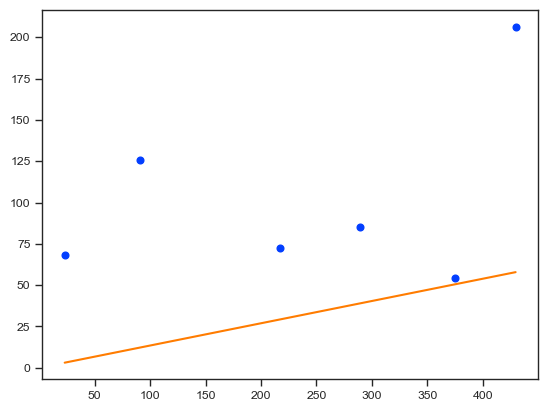

In [166]:
I = 108
print(df1.iloc[I].starts, df1.iloc[I].scs, df1.iloc[I].scs_reg)
plt.plot(str2float(df1.iloc[I].starts), str2float(df1.iloc[I].scs), 'o')
plt.plot(str2float(df1.iloc[I].starts), np.polyval([df1.iloc[I].scs_reg, 0], str2float(df1.iloc[I].starts)))
plt.show()

In [172]:
df1['scs_reg'].mean() * 60, df1['scs_reg'].sem() * 60 * 60

(2.3354319532822667, 11.839071659196728)

Serial dependence of LF

In [173]:
def serial_correlation(row):
    scs = str2float(row['lfs'])
    if len(scs) < 3:
        return np.nan
    corr = np.corrcoef(scs[:-1], scs[1:])[0, 1]
    return corr

data['lfs_serial_corr'] = data.apply(serial_correlation, axis=1)

data['lfs_serial_corr'].mean(), data['lfs_serial_corr'].sem()

(-0.049652033809106884, 0.011504099776625698)

Increase or decrease of LF during night

In [175]:
def regrr(row):
    if len(row['lfs']) < 3:
        return np.nan
    scs = str2float(row['lfs'])
    xcs = str2float(row['starts'])
    if len(scs) < 3:
        return np.nan
    return np.polyfit(xcs, scs, 1)[0]

df1['lfs_reg'] = df1.apply(regrr, axis=1)

df1['lfs_reg'].mean() * 60, df1['lfs_reg'].sem() * 60 * 60

(0.01000287504568513, 0.029839295090576857)

## No significant difference in IBN based regularity measure

In [186]:
def scs_m(row):
    scs = str2float(row['scs'])
    if len(scs) < 3:
        return np.nan
    return np.mean(scs)

def scs_sd(row):
    scs = str2float(row['scs'])
    if len(scs) < 3:
        return np.nan
    return np.std(scs)

data['m'] = data.apply(scs_m, axis=1)
data['s'] = data.apply(scs_sd, axis=1)

In [187]:
data['cv'] = data.s / data.m
data['ibn_cv'] = data.sigma / data.mu

In [203]:
data_ = data.query('ibn_cv < 1.8')

In [188]:
stats.wilcoxon(data_['cv'], data_['ibn_cv'])

WilcoxonResult(statistic=3630.0, pvalue=1.2371685148833012e-12)

In [204]:
print('CV:')
print('adult vs. young:', stats.mannwhitneyu(data_.query('age == "adult"')['cv'], data_.query('age == "young"')['cv']))
print('adult vs. subadult:', stats.mannwhitneyu(data_.query('age == "adult"')['cv'], data_.query('age == "subadult"')['cv']))
print('subadult vs. young:', stats.mannwhitneyu(data_.query('age == "subadult"')['cv'], data_.query('age == "young"')['cv']))

CV:
adult vs. young: MannwhitneyuResult(statistic=456.0, pvalue=0.00013041889327624647)
adult vs. subadult: MannwhitneyuResult(statistic=1676.0, pvalue=0.45761387979779977)
subadult vs. young: MannwhitneyuResult(statistic=62.0, pvalue=0.003537936478222105)


In [205]:
print('IBN-CV:')
print('adult vs. young:', stats.mannwhitneyu(data_.query('age == "adult"')['ibn_cv'], data_.query('age == "young"')['ibn_cv']))
print('adult vs. subadult:', stats.mannwhitneyu(data_.query('age == "adult"')['ibn_cv'], data_.query('age == "subadult"')['ibn_cv']))
print('subadult vs. young:', stats.mannwhitneyu(data_.query('age == "subadult"')['ibn_cv'], data_.query('age == "young"')['ibn_cv']))

IBN-CV:
adult vs. young: MannwhitneyuResult(statistic=856.0, pvalue=0.11255842060948171)
adult vs. subadult: MannwhitneyuResult(statistic=1895.0, pvalue=0.07363321908685885)
subadult vs. young: MannwhitneyuResult(statistic=94.0, pvalue=0.06431354959122743)


Higher interruption probabilities in younger animals

In [206]:
print('Pi:')
print('adult vs. young:', stats.mannwhitneyu(data_.query('age == "adult"')['pi'], data_.query('age == "young"')['pi']))
print('adult vs. subadult:', stats.mannwhitneyu(data_.query('age == "adult"')['pi'], data_.query('age == "subadult"')['pi']))
print('subadult vs. young:', stats.mannwhitneyu(data_.query('age == "subadult"')['pi'], data_.query('age == "young"')['pi']))

Pi:
adult vs. young: MannwhitneyuResult(statistic=551.0, pvalue=0.0009879459340609922)
adult vs. subadult: MannwhitneyuResult(statistic=1323.0, pvalue=0.34792167732735235)
subadult vs. young: MannwhitneyuResult(statistic=99.0, pvalue=0.09231058101189886)


In [207]:
(data.query('age == "young"').pi > 0.05).value_counts()

True     14
False     2
Name: pi, dtype: int64

In [208]:
(data.query('age == "subadult"').pi > 0.05).value_counts()

True     15
False     5
Name: pi, dtype: int64

In [209]:
(data.query('age == "adult"').pi > 0.05).value_counts()

True     84
False    69
Name: pi, dtype: int64

In [300]:
stats.chi2_contingency([[14, 15, 84], [2, 5, 69]])

Chi2ContingencyResult(statistic=8.555073426669225, pvalue=0.01387680256303785, dof=2, expected_freq=array([[ 9.56613757, 11.95767196, 91.47619048],
       [ 6.43386243,  8.04232804, 61.52380952]]))

In [213]:
(data.query('modal == "bimodal"').pi > 0.05).value_counts()

True     37
False     2
Name: pi, dtype: int64

In [214]:
(data.query('modal == "unimodal"').pi > 0.05).value_counts()

True     76
False    74
Name: pi, dtype: int64

## Degree of coordination decreases with spatial distance

In [295]:
pairs_ = pairs.query('delta > -1200 and delta < 1200')
pairs_.groupby('dist').agg({'u': ['mean', 'sem'], 'delta': ['mean', 'sem']})

u                 delta            
          mean       sem        mean         sem
dist                                            
0.0   0.801099  0.039783 -100.888889   50.878292
1.0   0.262464  0.029605    5.960000   83.416535
2.0   0.116874  0.032361 -122.777778  183.863686
3.0   0.159349  0.030188 -236.000000  191.752817

In [238]:
pairs.query('dist == 0').age2

0        young
1        young
2        young
3        young
4     subadult
5        young
6        young
7        young
8        young
9        young
10       young
12       young
14       young
15       adult
16       young
17       adult
18       adult
19       adult
20       young
Name: age2, dtype: object

## Young animals tend to stand up later and lie down earlier

In [241]:
pairs.delta.describe()

count      65.000000
mean        5.784615
std       534.627455
min     -1200.000000
25%      -313.000000
50%       -28.000000
75%       203.000000
max      1200.000000
Name: delta, dtype: float64

In [242]:
pairs_ = pairs.query('delta > -1200 and delta < 1200')
(-1 * pairs_.query('age2 == "young" and dist == 0').delta).aggregate(['mean', 'std', 'sem'])

mean    181.769231
std     182.606660
sem      50.645975
Name: delta, dtype: float64

In [258]:
print(stats.wilcoxon(pairs_.query('age2 == "young" and dist == 0').delta))
print(stats.wilcoxon(pairs_.query('(age2 == "young" or age1 == "young") and dist == 1').delta))
print(stats.wilcoxon(pairs_.query('(age2 == "young" or age1 == "young") and dist == 2').delta))

WilcoxonResult(statistic=3.0, pvalue=0.001220703125)
WilcoxonResult(statistic=145.0, pvalue=0.899570107460022)
WilcoxonResult(statistic=12.0, pvalue=0.4609375)


In [ ]:
young = set(pairs_.query('age2 == "young"').id2.unique())

three2two = lambda x: min(x, 2)

def sign_delta(row):
    if row.age2 == 'young':
        return -row.delta
    return row.delta

pairs_subsample = pd.DataFrame(columns=['young', 'other_0', 'delta_0', 'delta_1', 'delta_2'])
for y in young:
    pairs__ = pairs_.query(f'id2 == {y} or id1 == {y}')
    pairs__['dist'] = pairs__.dist.apply(three2two)
    if len(pairs__.dist.unique()) < 3:
        continue
    pairs__ = pairs__.groupby('dist').first().reset_index()
    pairs__['delta'] = pairs__.apply(sign_delta, axis=1)
    other_0 = pairs__.query('dist == 0').id1.values[0] if pairs__.id1.values[0] == y else pairs__.id1.values[0]
    pairs_subsample.loc[len(pairs_subsample)] = [y, other_0, *pairs__.delta]

In [279]:
stats.wilcoxon(pairs_subsample.delta_0.values, pairs_subsample.delta_1.values)

WilcoxonResult(statistic=4.0, pvalue=0.013671875)

In [280]:
stats.wilcoxon(pairs_subsample.delta_1.values, pairs_subsample.delta_2.values)

WilcoxonResult(statistic=23.0, pvalue=0.6953125)

In [282]:
data['FC'] = data['alpha'] / (data['alpha'] + data['beta']) * data['mu']

def FC_young(row):
    i = row.young
    FC = data.query(f'id == {i}')['FC'].values[0]
    return FC

pairs_subsample['FC_young'] = pairs_subsample.apply(FC_young, axis=1)

def FC_other(row):
    i = row.other_0
    FC = data.query(f'id == {i}')['FC'].values[0]
    return FC

pairs_subsample['FC_other'] = pairs_subsample.apply(FC_other, axis=1)

In [285]:
stats.wilcoxon(pairs_subsample.FC_young, pairs_subsample.FC_other)

WilcoxonResult(statistic=6.0, pvalue=0.02734375)

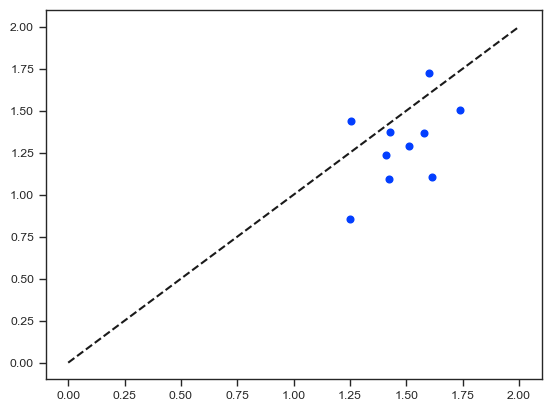

In [288]:
plt.plot(pairs_subsample.FC_young / 60, pairs_subsample.FC_other / 60, 'o')
plt.plot([0, 2], [0, 2], 'k--')